In [2]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads
!pip install --upgrade oci

In [3]:
# 필요 라이브러리 Import

import os
import ocifs
import oci
from ocifs import OCIFileSystem

import json
import base64
import numpy as np
import pandas as pd

import ads
from dask import dataframe as ddf

In [4]:
RP = os.environ.get("OCI_RESOURCE_PRINCIPAL_VERSION", "UNDEFINED")

if not RP or RP == "UNDEFINED":
    ads.set_auth(auth='api_key')
else:
    ads.set_auth(auth='resource_principal')

# 1. 데이터 로드 및 Data Cleansing

In [7]:
# ADB에서 crawled 데이터 로딩 
# 아래 USER_NAME, PASSWORD, SERVICE_NAME, WALLET_LOCATION을 본인의 ADB 정보로 변경

connection_parameters = {
    "user_name": "admin",
    "password": "Welcome123456!",
    "service_name": "o0mqv2sevcx6gmh9_low",
    "wallet_location": "./Wallet_O0MQV2SEVCX6GMH9.zip",
}

In [9]:
import pandas as pd
import ads

crawled_parquet_df = pd.DataFrame.ads.read_sql(
    """
    SELECT
    *
    FROM
    LIVELABS
    """,
    connection_parameters=connection_parameters,
)

In [10]:
crawled_parquet_df.head()

,ID,TITLE,URL,TYPE,DESCRIPTION,DURATION,PUBLISHED_TIME,TITLE_KO,DESC_KO,DURATION_KO,OCI_PRODUCTS,KEY_PHRASE
0,553,Manage and Monitor Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,The labs in this workshop show you a variety o...,3 hours,2017-09-02T01:47:14,Autonomous Database 관리 및 모니터링,이 워크샵의 실습에서는 Oracle Autonomous Database on Sha...,3시간,"refreshable database,adb-s","variety of ways,oracle autonomous database,sha..."
1,554,Low Code Development Oracle APEX on Autonomous...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,"Using APEX, developers can quickly develop and...",2 hours,2017-09-03T15:32:21,Autonomous Database의 로우 코드 개발 Oracle APEX,개발자는 APEX를 사용하여 실제 문제를 해결하고 즉각적인 가치를 제공하는 강력한 ...,2시간,"oracle apex,apps,apex","autonomous databaseusing apex,compelling apps,..."
2,560,Machine Learning on Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle integrates machine learning across the ...,2 hours,2017-09-04T05:55:07,Autonomous Database의 머신 러닝,Oracle은 Oracle Database와 Oracle Autonomous Dat...,2시간,"adb,machine learning notebooks,applications","machine learning,autonomous databaseoracle int..."
3,566,Boost Analytics Performance with Oracle Databa...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle Database In-Memory provides a unique du...,"1 hour, 30 minutes",2017-09-06T02:51:59,Oracle Database In-Memory를 통한 분석 성능 향상,Oracle Database In-Memory는 기존의 행 형식과 새로운 in-me...,1시간 30분,im,"oracle database 21c,database in-memory,im colu..."
4,567,Oracle WebLogic Server Kubernetes Operator Tut...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,This workshop provides the process of moving a...,1 hour,2017-09-08T04:47:41,Oracle WebLogic Server Kubernetes Operator 자습서,이 워크샵은 기존 WebLogic 서버 애플리케이션을 Oracle Public Cl...,1시간,"oracle cloud,oracle public cloud,weblogic serv...","existing weblogic server application,kubernete..."


In [11]:
#한국어 및 테스트 데이터 삭제 
df_final=crawled_parquet_df.drop([402,409,462,774,788])

---

# 2. Natural Language Processing(자연어 처리)

NLP(Natural Language Processing, 자연어 처리)는 인공지능의 한 분야로서 머신러닝을 사용하여 텍스트와 데이터를 처리하고 해석합니다. 자연어 처리를 위해서는 원시 텍스트를 모델과 시스템에서 읽을 수 있는 형식으로 변환하기 위한 몇 가지 사전 처리 단계가 필요합니다. 

1. **Tokenization(토큰화)** - 텍스트를 개별 구성 단어로 분리합니다.
2. **Stopwords(불용어 처리)** - 너무 자주 발생하는 단어는 삭제합니다. 발생 빈도가 관련 텍스트를 감지하는 데 도움이 되지 않습니다.(매우 드물게 발생하는 단어를 버리는 것도 고려하세요).
3. **Stemmization(어간 추출)** - 변형된 단어를 동일한 의미를 전달하는 단일 상위 단어로 결합합니다.
4. **Vectorization(벡터화)** - 텍스트를 벡터 형식으로 변환합니다. 간단한 방식 중 하나는 bag-of-words 접근 방식(단어 빈도 저장)입니다. 

---

# 3. Topic Modeling(주제 모델링)
## 3a. 모든 전처리 단계 통합

In [12]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [13]:
# nan과 null 데이터 처리를 위해 desc열만 dataframe으로 변환 
# 최종 dataframe를 list에 저장

pd.set_option('display.max_rows',None)
df_final1 = pd.DataFrame({'document':df_final.DESCRIPTION})
df_final2 = df_final1.dropna()
df_final3 = df_final2[df_final2['document'].astype(bool)]
text = list(df_final3.document.values)
text[1:5]

["Using APEX, developers can quickly develop and deploy compelling apps that solve real problems and provide immediate value. You won't need to be an expert in a vast array of technologies to deliver sophisticated solutions. Focus on solving the problem and let APEX take care of the rest.",
 'Oracle integrates machine learning across the Oracle stack and the enterprise, fully leveraging Oracle Database and Oracle Autonomous Database.  In this workshop, create a machine learning model and move the model to ADB.  Explore machine learning notebooks and use prediction in applications.',
 'Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to p

In [14]:
# Countvectorizer 호출
    
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)
tf

<525x1778 sparse matrix of type '<class 'numpy.int64'>'
	with 17287 stored elements in Compressed Sparse Row format>

## 3b. Latent Dirichlet Allocation

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=15, max_iter=10,
                                learning_method = 'online',
                                learning_offset = 10.,
                                random_state = 0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=0)

### LDA에서 생성된 주제

In [16]:
# top words를 출력하는 헬퍼 함수 정의

n_top_words = 30
tf_feature_names = tf_vectorizer.get_feature_names()

def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
        
print("\nTopics in LDA model: ")

print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:hpc function infrastructure oracle compute application workload cloud performance software run capacity issue provides cost needed learning computing faster build like instance enabling engineering saving avoid utilization intensive high innovate

Topic #1:document json relational developer view partitioning table duality database oracle feature file partition access building data automatic flexibility benefit 23c apps simplicity auto information department challenge overcomes breakthrough faced historical

Topic #2:database oracle cloud service management oci security lab workshop infrastructure using application performance access use solution data workload help user including enterprise identity provides governance premise instance learn experience step

Topic #3:application oracle cloud workshop create oci data using user learn database service lab end step use infrastructure app kubernetes process web environment walk set instance cluster developer

### 주제의 Word Cloud 시각화

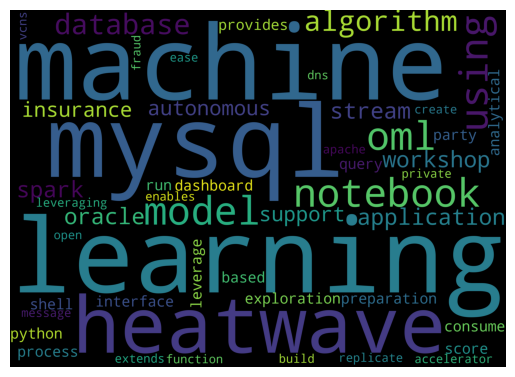

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

first_topic = lda.components_[13]
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
firstcloud = WordCloud(   stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [18]:
# 각 문서에 대한 주요 topic 가져오기

doc_topics=lda.transform(tf)
topic_index=list(df_final3.index.values)
topic_names = ['Topic #'+str(i) for i in range(0,15)]
topic_df = pd.DataFrame(data=doc_topics, columns=topic_names, index=topic_index)

dominant_topic = np.argmax(topic_df.values, axis=1)
topic_df['dominant_topic'] = dominant_topic

# Styling

def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color : {col}'.format(col=color)

def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)

# Apply Style

df_document_topics = topic_df.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,dominant_topic
0,0.001212,0.001212,0.342298,0.001212,0.066917,0.001212,0.001212,0.001212,0.576240,0.001212,0.001212,0.001212,0.001212,0.001212,0.001212,8
1,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.967816,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,6
2,0.002299,0.002299,0.368516,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.601599,0.002299,13
3,0.001058,0.001058,0.431515,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.554728,0.001058,0.001058,0.001058,11
4,0.003922,0.003922,0.003922,0.945098,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3
5,0.001626,0.855744,0.001626,0.001626,0.001626,0.001626,0.001626,0.001626,0.123117,0.001626,0.001626,0.001626,0.001626,0.001626,0.001626,1
6,0.001587,0.001587,0.924590,0.001587,0.001587,0.001587,0.001587,0.054775,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,2
7,0.002083,0.002083,0.002083,0.363517,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.609400,0.002083,13
8,0.003509,0.003509,0.614266,0.003509,0.340120,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,2
9,0.002381,0.002381,0.002381,0.276320,0.002381,0.002381,0.002381,0.002381,0.692728,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,8


### 구현된 lda 모델을 사용해서 sample 문구를 입력하여 sample 문구에 해당되는 Topic 할당

In [19]:
sample = ["I want to learn MACHINE LEARNING on HEATWAVE"]
sample_vec = tf_vectorizer.transform(sample)
topic_probability_scores = lda.transform(sample_vec)
topic_chosen = np.argmax(topic_probability_scores)
print(topic_chosen)

13


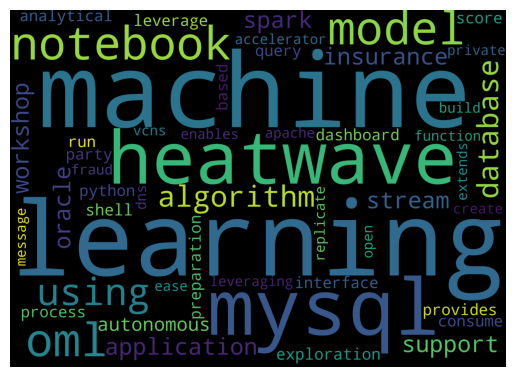

In [20]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
firstcloud = WordCloud(   stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [21]:
df_document_topics = topic_df.style.applymap(color_green).applymap(make_bold)
topic_data = df_document_topics.data
topic_data.loc[topic_data['dominant_topic']==topic_chosen]

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,dominant_topic
2,0.002299,0.002299,0.368516,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.601599,0.002299,13
7,0.002083,0.002083,0.002083,0.363517,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.609400,0.002083,13
11,0.001626,0.001626,0.001626,0.341659,0.001626,0.001626,0.001626,0.001626,0.129760,0.001626,0.001626,0.001626,0.001626,0.509068,0.001626,13
154,0.001418,0.001418,0.001418,0.001418,0.001418,0.001418,0.293696,0.001418,0.001418,0.001418,0.001418,0.001418,0.001418,0.687864,0.001418,13
161,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.948148,0.003704,13
218,0.006061,0.006061,0.323253,0.006061,0.006061,0.006061,0.006061,0.006061,0.006061,0.006061,0.006061,0.006061,0.006061,0.597959,0.006061,13
237,0.001190,0.001190,0.337713,0.208356,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.439645,0.001190,13
244,0.001258,0.001258,0.152340,0.150850,0.001258,0.001258,0.001258,0.001258,0.206025,0.001258,0.001258,0.001258,0.001258,0.476948,0.001258,13
254,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.386842,0.008333,0.008333,0.008333,0.008333,0.504825,0.008333,13
461,0.000694,0.000694,0.174230,0.249223,0.000694,0.000694,0.000694,0.000694,0.224152,0.000694,0.000694,0.000694,0.000694,0.344755,0.000694,13


In [22]:
indices = topic_data.index[topic_data['dominant_topic'] == topic_chosen]
print(indices)

for index in indices:
    print(crawled_parquet_df.loc[index])
    print(   )

Int64Index([2, 7, 11, 154, 161, 218, 237, 244, 254, 461, 465, 548, 580, 584], dtype='int64')
ID                                                              560
TITLE                       Machine Learning on Autonomous Database
URL               https://apexapps.oracle.com/pls/apex/r/dbpm/li...
TYPE                                                       Hands-on
DESCRIPTION       Oracle integrates machine learning across the ...
DURATION                                                    2 hours
PUBLISHED_TIME                                  2017-09-04T05:55:07
TITLE_KO                                 Autonomous Database의 머신 러닝
DESC_KO           Oracle은 Oracle Database와 Oracle Autonomous Dat...
DURATION_KO                                                     2시간
OCI_PRODUCTS            adb,machine learning notebooks,applications
KEY_PHRASE        machine learning,autonomous databaseoracle int...
Name: 2, dtype: object

ID                                                              577

---

# 4. KMeans Clustering

In [23]:
topic_df.head()

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,dominant_topic
0,0.001212,0.001212,0.342298,0.001212,0.066917,0.001212,0.001212,0.001212,0.576240,0.001212,0.001212,0.001212,0.001212,0.001212,0.001212,8
1,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.967816,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,6
2,0.002299,0.002299,0.368516,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.002299,0.601599,0.002299,13
3,0.001058,0.001058,0.431515,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.554728,0.001058,0.001058,0.001058,11
4,0.003922,0.003922,0.003922,0.945098,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3


In [24]:
X=topic_df.drop(['dominant_topic'],axis=1)
y=topic_df['dominant_topic']

In [25]:
from sklearn.cluster import KMeans

# Perform clustering
kmeans = KMeans(n_clusters=15, random_state=0)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the topic_df
topic_df['cluster'] = clusters

# Display data for each cluster
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
for cluster_id in range(11):
    print(f"Cluster {cluster_id}:")
    cluster_data = topic_df[topic_df['cluster'] == cluster_id]
    print(cluster_data)
    print()

Cluster 0:
     Topic #0  Topic #1  Topic #2  Topic #3  Topic #4  Topic #5  Topic #6  Topic #7  Topic #8  Topic #9  Topic #10  Topic #11  Topic #12  Topic #13  Topic #14  dominant_topic  cluster
6    0.001587  0.001587  0.924590  0.001587  0.001587  0.001587  0.001587  0.054775  0.001587  0.001587  0.001587   0.001587   0.001587   0.001587   0.001587   2               0      
15   0.003175  0.003175  0.955555  0.003175  0.003175  0.003175  0.003175  0.003175  0.003175  0.003175  0.003175   0.003175   0.003175   0.003175   0.003175   2               0      
17   0.002083  0.002083  0.970833  0.002083  0.002083  0.002083  0.002083  0.002083  0.002083  0.002083  0.002083   0.002083   0.002083   0.002083   0.002083   2               0      
19   0.009524  0.009524  0.763379  0.009524  0.009524  0.009524  0.009524  0.112812  0.009524  0.009524  0.009524   0.009524   0.009524   0.009524   0.009524   2               0      
30   0.002083  0.002083  0.843860  0.002083  0.002083  0.002083  0.00